# Counterfactual Regret Minimization Implementation for Basic Games

Counterfactual regret minimization is an important algorithm behind powerful poker AI and solver technology. We will be going through some basic strategy game solutions to demonstrate the concepts. 

**For Some Number of Iterations:**
   * Compute a regret-matching strategy
   * Add strategy profile to the profile sum
   * Select each player action profile according to the strategy profile
   * Compute regrets
   * Add player regrets to player cumulative regrets
   * Return the average strategy profile

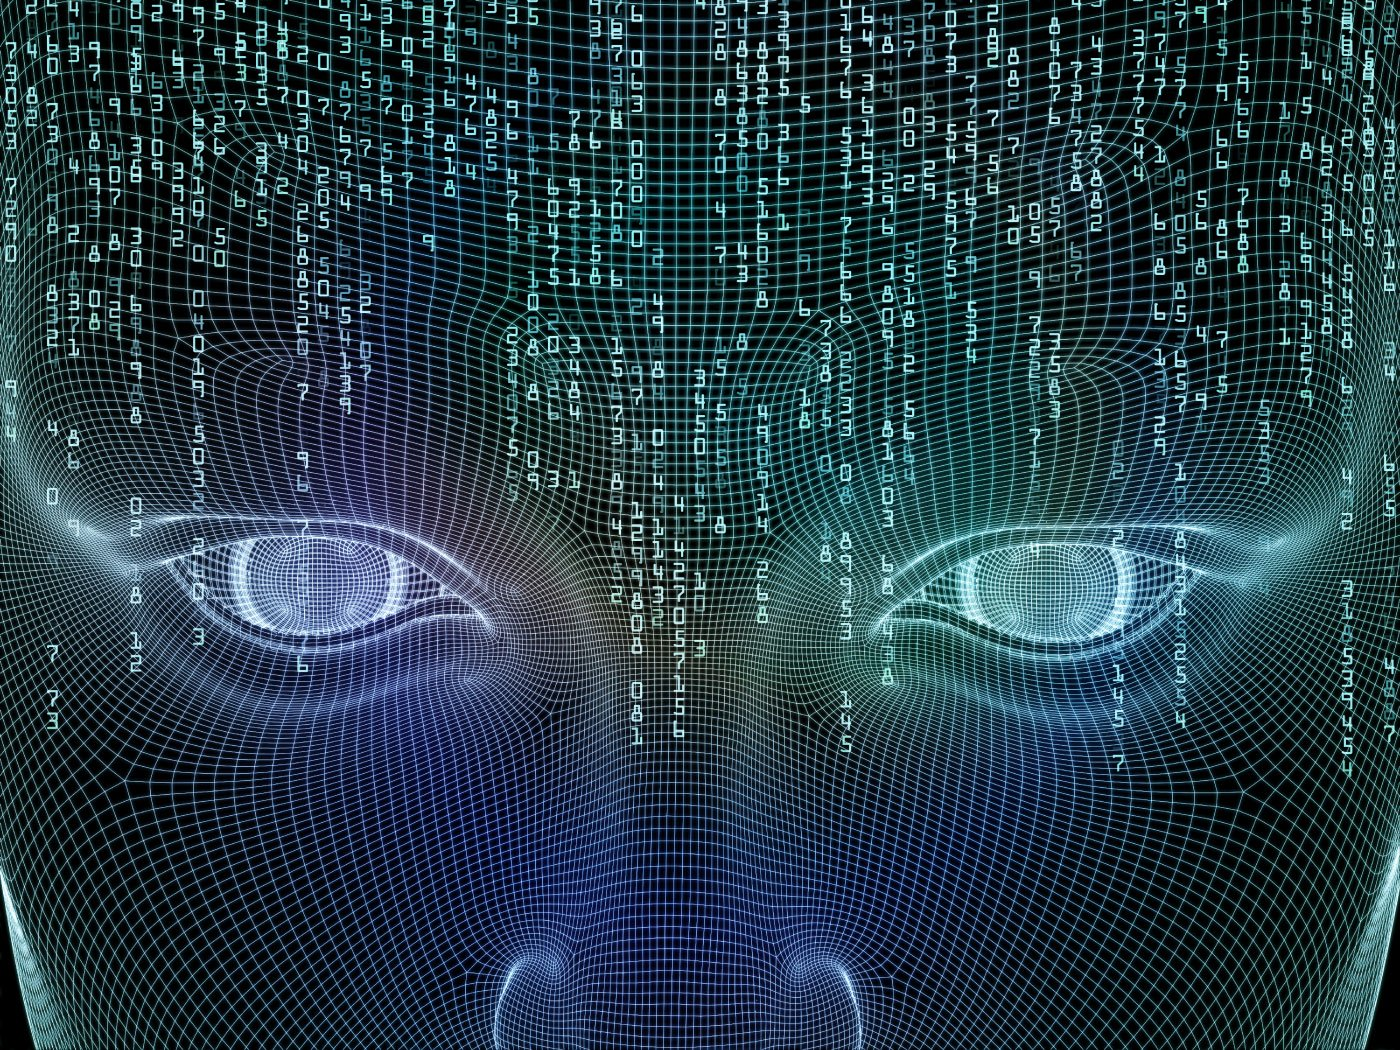

 ## Example 1: Rock Paper Scissors
Rock Paper Scissors (RPS) is one of the most straightforward and basic strategy games. We will be demonstrating the basic concepts of the game first, and gradually build up to more complex games.
### Key Variables:

* Indices to acess options in strategy list
* regretSum: A list to keep track of the total regret of each decision
* strategy: A list to hold the weightings of each option in a mixed strategy
* strategySum: The sum of all the strategies used thus far
* oppStrategy: The strategy of a theoretical opponent against whom we must adjust

In [1]:
import random

### Regret Matching
 * Computes the strategy as the accumulated regrets / total regret
 * Computes the strategySum as the given strategySum + the newly derived strategy based on accumulated regrets

In [2]:

def getStrategy(regretSum,strategySum):
    actions = 3
    normalizingSum = 0
    strategy = [0,0,0]
    #Normalizingsum is the sum of positive regrets
    for i in range(0,actions):
        if regretSum[i] > 0:
            strategy[i] = regretSum[i]
        else:
            strategy[i] = 0
        normalizingSum += strategy[i]
        
    for i in range(0,actions):
        if normalizingSum > 0:
            strategy[i] = strategy[i]/normalizingSum
        else:
            strategy[i] = 1.0 / actions
        strategySum[i] += strategy[i]
    return (strategy,strategySum)

### Pull A Random Action According To Current Mixed Strategy

In [3]:
#Returns a random action according to the strategy
def getAction(strategy):
    r = random.uniform(0,1)
    if r >= 0 and r < strategy[0]:
        return 0
    elif r >= strategy[0] and r < strategy[0] + strategy[1]:
        return 1
    elif r >= strategy[0] + strategy[1] and r < sum(strategy):
        return 2
    else:
        return 0

### Training Algorithm
- Accumulate regretSums after every round
- Compute a regret-matching strategy based on those regret sums
- Add Strategy to the sum of all the previously computed profiles

In [4]:
def train(iterations,regretSum,oppStrategy):
    actionUtility = [0,0,0]
    strategySum = [0,0,0]
    actions = 3
    for i in range(0,iterations):
        
        ##Retrieve Actions
        t = getStrategy(regretSum,strategySum)
        strategy = t[0]
        strategySum = t[1]
        #print(strategy)
        myaction = getAction(strategy)
        #Define an arbitrary opponent strategy from which to adjust
        otherAction = getAction(oppStrategy)
        
        #Opponent Chooses scissors
        if otherAction == actions - 1:
            #Utility(Rock) = 1
            actionUtility[0] = 1
            #Utility(Paper) = -1
            actionUtility[1] = -1
        #Opponent Chooses Rock
        elif otherAction == 0:
            #Utility(Scissors) = -1
            actionUtility[actions - 1] = -1
            #Utility(Paper) = 1
            actionUtility[1] = 1
        #Opopnent Chooses Paper
        else:
            #Utility(Rock) = -1
            actionUtility[0] = -1
            #Utility(Scissors) = 1
            actionUtility[2] = 1
            
        #Add the regrets from this decision
        for i in range(0,actions):
            regretSum[i] += actionUtility[i] - actionUtility[myaction]
    return strategySum
        

### Compute the average strategy
- Returns the average strategy profile as each option divided by the total sum of all options

In [5]:
def getAverageStrategy(iterations,oppStrategy):
    actions = 3
    strategySum = train(iterations,[0,0,0],oppStrategy)
    avgStrategy = [0,0,0]
    normalizingSum = 0
    for i in range(0,actions):
        normalizingSum += strategySum[i]
    for i in range(0,actions):
        if normalizingSum > 0:
            avgStrategy[i] = strategySum[i] / normalizingSum
        else:
            avgStrategy[i] = 1.0 / actions
    return avgStrategy

### Run the algorithm!
* Demonstrates that we can generate a maximally exploitative strat

In [14]:
oppStrat = [.4,.3,.3]
print("Opponent's Strategy",oppStrat)
#train(1000000,[0,0,0],[.4,.3,.3])
print("Maximally Exploitative Strat", getAverageStrategy(1000000,oppStrat))

Opponent's Strategy [0.4, 0.3, 0.3]
Maximally Exploitative Strat [6.666666666666666e-07, 0.999999, 3.333333333333333e-07]


### Have Both Agents Converge to Nash Equilibrium
   * We will adapt our training algorithm to train two agents simulataneously

In [32]:
#Two player training Function
def train2Player(iterations,regretSum1,regretSum2,p2Strat):
    ##Adapt Train Function for two players
    actions = 3
    actionUtility = [0,0,0]
    strategySum1 = [0,0,0]
    strategySum2 = [0,0,0]
    for i in range(0,iterations):
        
        ##Retrieve Actions
        t1 = getStrategy(regretSum1,strategySum1)
        strategy1 = t1[0]
        strategySum1 = t1[1]
        myaction = getAction(strategy1)
        t2 = getStrategy(regretSum2,p2Strat)
        strategy2 = t2[0]
        strategySum2 = t2[1]
        otherAction = getAction(strategy2)
        
        #Opponent Chooses scissors
        if otherAction == actions - 1:
            #Utility(Rock) = 1
            actionUtility[0] = 1
            #Utility(Paper) = -1
            actionUtility[1] = -1
        #Opponent Chooses Rock
        elif otherAction == 0:
            #Utility(Scissors) = -1
            actionUtility[actions - 1] = -1
            #Utility(Paper) = 1
            actionUtility[1] = 1
        #Opopnent Chooses Paper
        else:
            #Utility(Rock) = -1
            actionUtility[0] = -1
            #Utility(Scissors) = 1
            actionUtility[2] = 1
            
        #Add the regrets from this decision
        for i in range(0,actions):
            regretSum1[i] += actionUtility[i] - actionUtility[myaction]
            regretSum2[i] += -(actionUtility[i] - actionUtility[myaction])
            
    return (strategySum1, strategySum2)

#Returns a nash equilibrium reached by two opponents through CFRM
def RPStoNash(iterations,oppStrat):
    strats = train2Player(iterations,[0,0,0],[0,0,0],oppStrat)
    s1 = sum(strats[0])
    s2 = sum(strats[1])
    for i in range(3):
        if s1 > 0:
            strats[0][i] = strats[0][i]/s1
        if s2 > 0:
            strats[1][i] = strats[1][i]/s2
    return strats


In [33]:
print(RPStoNash(1000000,[.4,.3,.3]))

([0.34083239238186, 0.3340920629119219, 0.3250755447062181], [0.32967926313477963, 0.33222032740623947, 0.3381004094589809])


## Colonel Blotto Example

Colonel Blotto and his arch-enemy, Boba Fett, are at war. **Each commander has S soldiers in total**, and **each soldier can be assigned to one of N < S battlefields.** Naturally, these commanders do not communicate and hence direct their soldiers independently. **Any number of soldiers can be allocated to each battlefield, including zero.** A commander claims a battlefield **if they send more soldiers to the battlefield than their opponent.** The commander’s job is to break down his pool of soldiers into groups to which he assigned to each battlefield. **The winning commander is the one who claims the most battlefields.** For example, with (S,N) = (10,4) a Colonel Blotto may choose to play (2,2,2,4) while Boba Fett may choose to play (8,1,1,0). In this case, Colonel Blotto would win by claiming three of the four battlefields. **The war ends in a draw if both commanders claim the same number of battlefields.**

Write a program where each player alternately uses regret-matching to find a Nash equilibrium for this game with **S = 5 and N = 3.** Some advice: before starting the training iterations, first think about all the valid pure strategies for one player; then, assign each pure strategy an ID number. Pure strategies can be represented as strings, objects, or 3-digit numbers: make a global array of these pure strategies whose indices refer to the ID of the strategy. Then, make a separate function that returns the utility of the one of the players given the IDs of the strategies used by each commander.

In [ ]:
class ColonelBlottoTrainer:
    def __init__(self):
        #soldiers
        s = 5
        #Battle fields
        n = 3
        

## Kuhn Poker Example

## 1-Die vs 1-Die Dudo

## Liar Die

# References
* [1] Introduction to Counterfactual Regret Minimization: http://modelai.gettysburg.edu/2013/cfr/cfr.pdf

In [22]:
([0,0,0],1)[0]

[0, 0, 0]